**Appendix**

Q1a

In [241]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import copy
from tqdm import tqdm


class PolyakSGD(torch.optim.Optimizer):

    
    def __init__(self, params, epsilon=1e-8, f_star=0.0, weight_decay=0):
        defaults = dict(epsilon=epsilon, f_star=f_star, weight_decay=weight_decay)
        super(PolyakSGD, self).__init__(params, defaults)
        self.step_sizes = []  # Store step sizes for analysis
        
    def step(self, closure=None):
        if closure is None:
            raise ValueError("Polyak SGD requires closure to compute the current loss value")
            
        # Get current loss value
        loss = closure()
        
        # Calculate squared norm of the gradient
        grad_squared_norm = 0.0
        
        # Process all parameter groups
        for group in self.param_groups:
            epsilon = group['epsilon']
            f_star = group['f_star']
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                
                # Get gradients
                d_p = p.grad.data
                
                # Add weight decay if specified
                if weight_decay != 0:
                    d_p = d_p.add(p.data, alpha=weight_decay)
                
                # Accumulate squared norm of gradients
                grad_squared_norm += torch.sum(d_p * d_p).item()
        
        # Calculate Polyak step size
        step_size = (loss.item() - f_star) / (grad_squared_norm + epsilon)
        
        # Ensure step size is positive
        step_size = max(step_size, 0.0)
        
        # Store step size for analysis
        self.step_sizes.append(step_size)
        
        # Apply updates using the computed step size
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                d_p = p.grad.data
                
                # Apply weight decay if specified
                if weight_decay != 0:
                    d_p = d_p.add(p.data, alpha=weight_decay)
                
                # Update parameters
                p.data.add_(d_p, alpha=-step_size)
        
        return loss




In [242]:
# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate quadratic dataset: y = 2x² + 1
X = torch.linspace(-20, 20, 1000).unsqueeze(1)
X_poly = torch.cat([X, X**2], dim=1)
y = 2 * X**2 + 1
dataset = TensorDataset(X_poly, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model: Linear layer with inputs [x, x²]
class QuadModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(2, 1)
    def forward(self, xp):
        return self.lin(xp)

model = QuadModel().to(device)


Using device: cuda


In [243]:
# Optimizer and loss
optimizer = PolyakSGD(model.parameters(), f_star=0.0, epsilon=1e-8)
criterion = torch.nn.MSELoss()

# Logging
epoch_losses = []
w1_hist, w2_hist = [], []

epochs = 500
for epoch in range(epochs):
    last_loss = None
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        def closure():
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        last_loss = loss.item()  # <- capture last batch loss

    epoch_losses.append(last_loss)  # use last mini-batch loss only
    
    w1, w2 = model.lin.weight.detach().cpu().numpy()[0]
    w1_hist.append(w1)
    w2_hist.append(w2)
    
    print(f"Epoch {epoch+1:2d} - Final Loss: {last_loss:.6f}")


Epoch  1 - Final Loss: 0.747267
Epoch  2 - Final Loss: 1.478005
Epoch  3 - Final Loss: 6.755783
Epoch  4 - Final Loss: 688.715027
Epoch  5 - Final Loss: 0.746661
Epoch  6 - Final Loss: 0.497450
Epoch  7 - Final Loss: 0.591710
Epoch  8 - Final Loss: 11.728971
Epoch  9 - Final Loss: 0.149050
Epoch 10 - Final Loss: 0.580745
Epoch 11 - Final Loss: 0.441915
Epoch 12 - Final Loss: 0.708740
Epoch 13 - Final Loss: 0.788098
Epoch 14 - Final Loss: 0.106999
Epoch 15 - Final Loss: 1.016444
Epoch 16 - Final Loss: 0.143221
Epoch 17 - Final Loss: 0.155469
Epoch 18 - Final Loss: 0.468825
Epoch 19 - Final Loss: 0.129709
Epoch 20 - Final Loss: 0.255198
Epoch 21 - Final Loss: 0.082032
Epoch 22 - Final Loss: 0.138971
Epoch 23 - Final Loss: 0.115627
Epoch 24 - Final Loss: 0.097574
Epoch 25 - Final Loss: 0.083301
Epoch 26 - Final Loss: 0.528609
Epoch 27 - Final Loss: 1.860178
Epoch 28 - Final Loss: 0.088549
Epoch 29 - Final Loss: 2.030091
Epoch 30 - Final Loss: 0.113221
Epoch 31 - Final Loss: 6.644392
Epoch

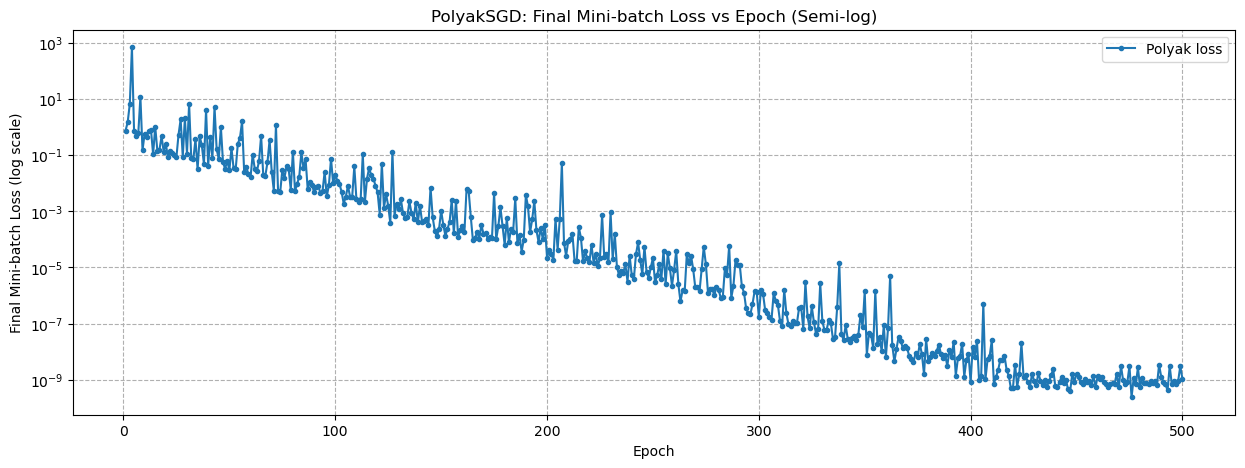

In [244]:
# Plot: Loss (last mini-batch of each epoch) vs Epoch on a semi-log scale
plt.figure(figsize=(15,5))
plt.semilogy(range(1, epochs + 1), epoch_losses, marker='.',label='Polyak loss')
plt.xlabel("Epoch")
plt.ylabel("Final Mini-batch Loss (log scale)")
plt.title("PolyakSGD: Final Mini-batch Loss vs Epoch (Semi-log)")
plt.grid(True, which="both", linestyle='--')
plt.legend()
plt.show()



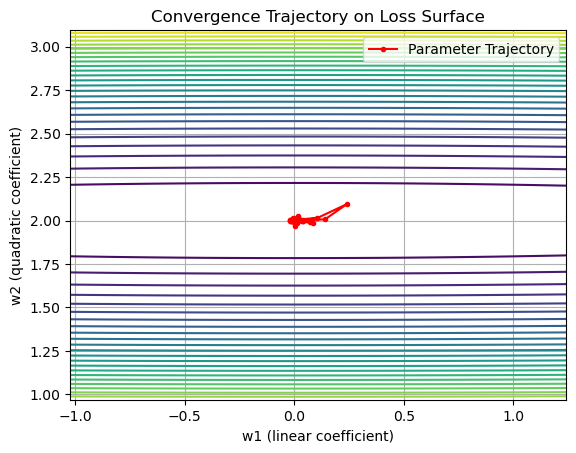

In [245]:
# Create contour grid over w1, w2
w1_vals = np.linspace(min(w1_hist)-1, max(w1_hist)+1, 100)
w2_vals = np.linspace(min(w2_hist)-1, max(w2_hist)+1, 100)
W1, W2 = np.meshgrid(w1_vals, w2_vals)

X_np = X.numpy()
y_np = y.numpy()
Z = np.zeros_like(W1)

# Compute loss surface
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        preds = W1[i, j] * X_np + W2[i, j] * X_np**2 + 1
        Z[i, j] = np.mean((preds - y_np)**2)

# Plot contours and parameter path
plt.figure()
CS = plt.contour(W1, W2, Z, levels=30)
# plt.clabel(CS, inline=True, fontsize=8)
plt.plot(w1_hist, w2_hist, marker='.', color='red', label='Parameter Trajectory')
plt.xlabel('w1 (linear coefficient)')
plt.ylabel('w2 (quadratic coefficient)')
plt.title('Convergence Trajectory on Loss Surface')
plt.legend()
plt.grid(True)
plt.show()


Q1b

In [261]:
def generate_data(n=500, noise_std=1.0):
    X = torch.linspace(-10, 10, n).unsqueeze(1)
    y = 3 * X + 1 + noise_std * torch.randn_like(X)
    return X, y

class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x):
        return self.linear(x)


In [262]:
def train_constant_sgd(X, y, lr=0.01, batch_size=32, epochs=20):
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = LinearModel()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    losses = []
    param_traj = []

    for epoch in tqdm(range(epochs)):
        for xb, yb in loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        w, b = model.linear.weight.item(), model.linear.bias.item()
        param_traj.append((w, b))

    return losses, model, param_traj


In [263]:

def train_polyak_sgd(X, y, batch_size=32, epochs=20):
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = LinearModel()
    optimizer = PolyakSGD(model.parameters(), f_star=0.0, epsilon=1e-8)
    criterion = torch.nn.MSELoss()

    losses = []
    epoch_step_sizes = []
    param_traj = []

    for epoch in range(epochs):
        last_step_size = None

        for xb, yb in loader:
            def closure():
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                return loss

            loss = optimizer.step(closure)
            last_step_size = optimizer.step_sizes[-1]  # capture final mini-batch step size

        epoch_step_sizes.append(last_step_size)
        losses.append(loss.item())
        w, b = model.linear.weight.item(), model.linear.bias.item()
        param_traj.append((w, b))

    return losses, model, epoch_step_sizes, param_traj



In [264]:
# Settings
noise_levels = [0,1.0, 5.0]
batch_sizes = [16, 64,256,500]
epochs = 20
lr = 0.01

results = {}


for noise in noise_levels:
    for bs in batch_sizes:
        key = f"noise={noise}, bs={bs}"
        X, y = generate_data(noise_std=noise)
        const_losses, _, const_traj = train_constant_sgd(X, y, lr=lr, batch_size=bs, epochs=epochs)
        poly_losses, _, poly_steps, poly_traj = train_polyak_sgd(X, y, batch_size=bs, epochs=epochs)
        results[key] = {
            'constant': const_losses,
            'polyak': poly_losses,
            'step_sizes': poly_steps,
            'const_traj': const_traj,
            'poly_traj': poly_traj
        }


100%|██████████| 20/20 [00:00<00:00, 116.28it/s]


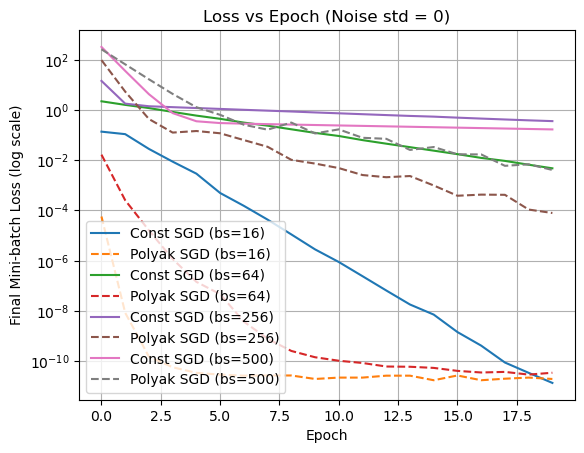

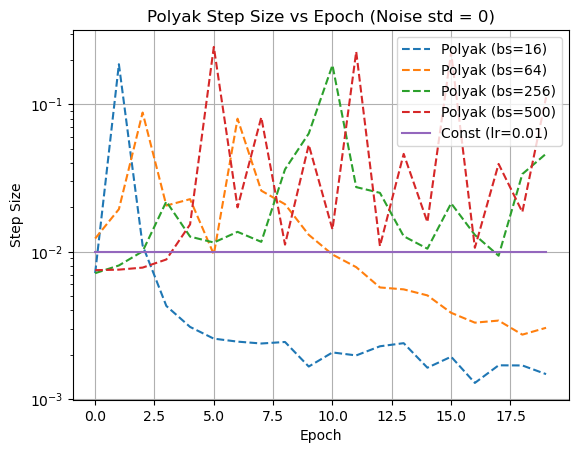

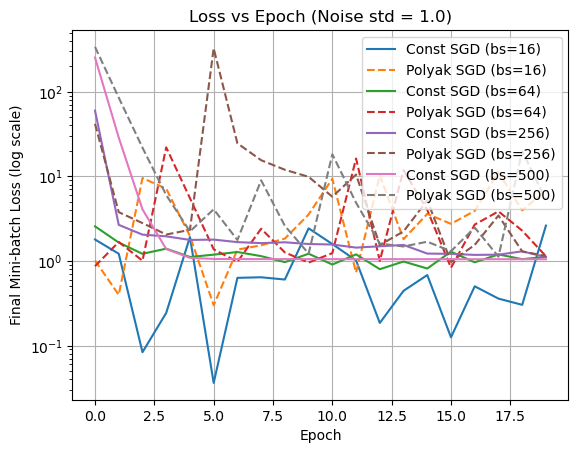

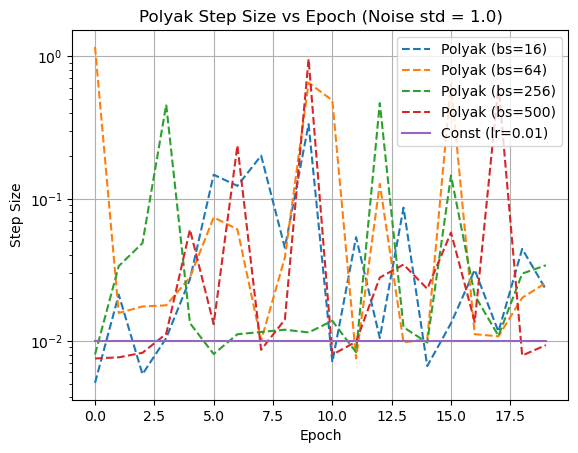

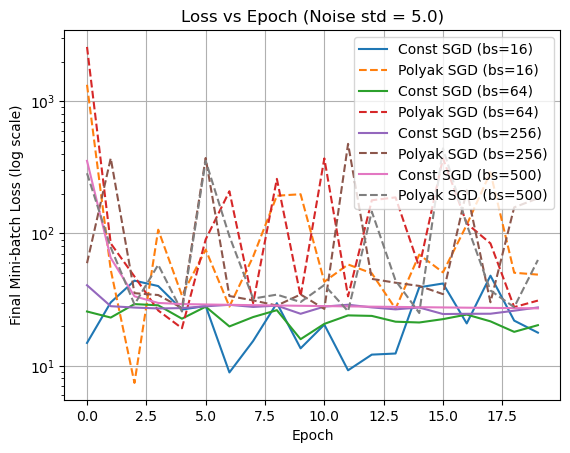

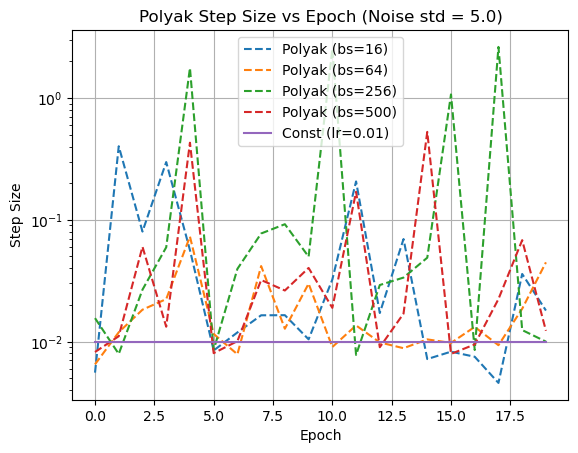

In [265]:
# Group plots by noise level
unique_noises = sorted(set(k.split(',')[0].split('=')[1] for k in results.keys()))
const_lr = 0.01

for noise in unique_noises:
    fig_loss, ax_loss = plt.subplots()
    fig_step, ax_step = plt.subplots()

    for key in results:
        key_noise = key.split(',')[0].split('=')[1]
        key_bs = key.split(',')[1].split('=')[1].strip()

        if key_noise == noise:
            val = results[key]
            ax_loss.semilogy(val['constant'], label=f'Const SGD (bs={key_bs})')
            ax_loss.semilogy(val['polyak'], linestyle='--', label=f'Polyak SGD (bs={key_bs})')

            ax_step.semilogy(val['step_sizes'],  linestyle='--',label=f'Polyak (bs={key_bs})')

    ax_loss.set_title(f"Loss vs Epoch (Noise std = {noise})")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Final Mini-batch Loss (log scale)")
    ax_loss.legend()
    ax_loss.grid(True)

    ax_step.set_title(f"Polyak Step Size vs Epoch (Noise std = {noise})")
    ax_step.plot([const_lr] * len(val['step_sizes']), label=f'Const (lr=0.01)', linestyle='-')

    ax_step.set_xlabel("Epoch")
    ax_step.set_ylabel("Step Size")
    ax_step.legend()
    ax_step.grid(True)

    plt.show()
    



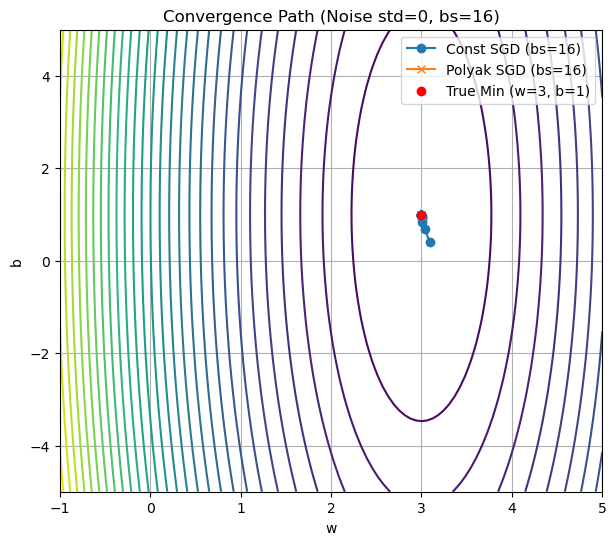

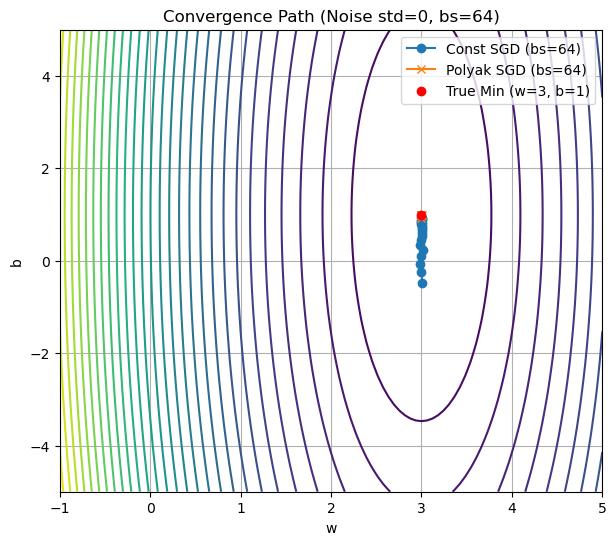

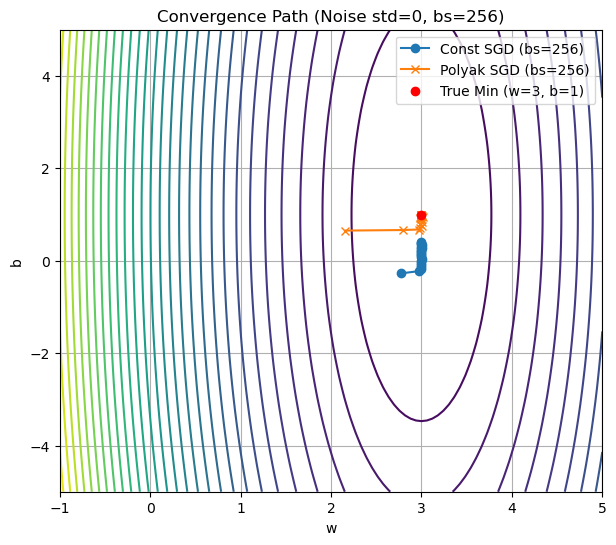

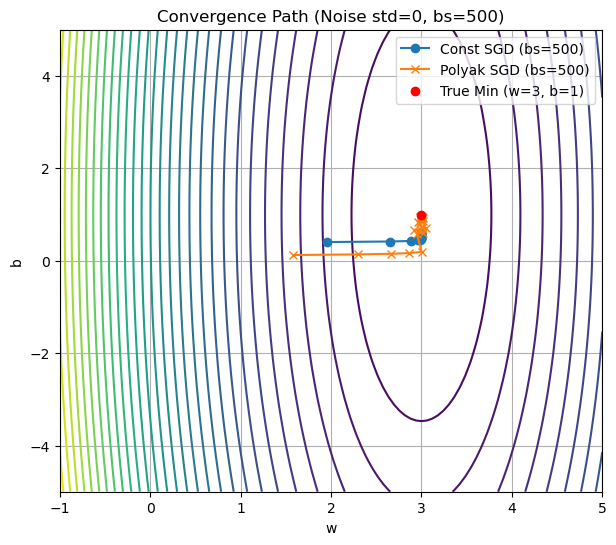

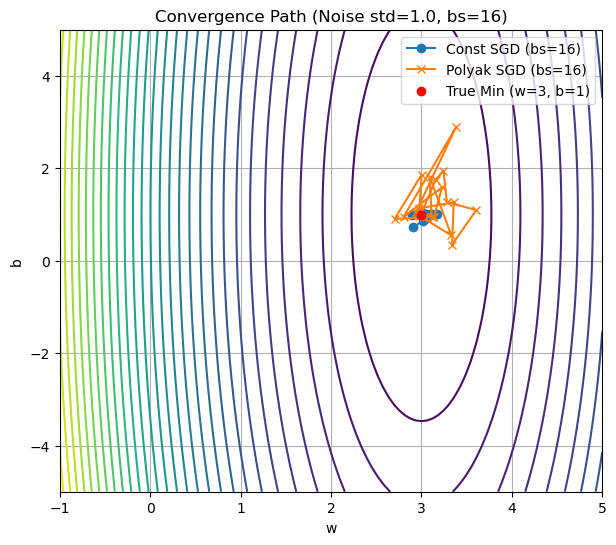

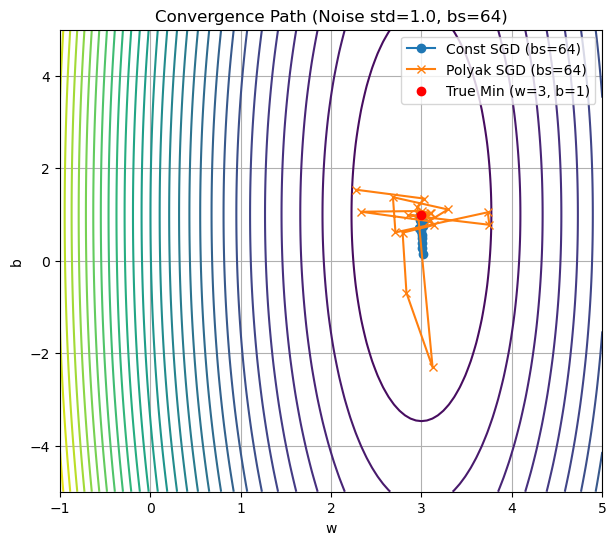

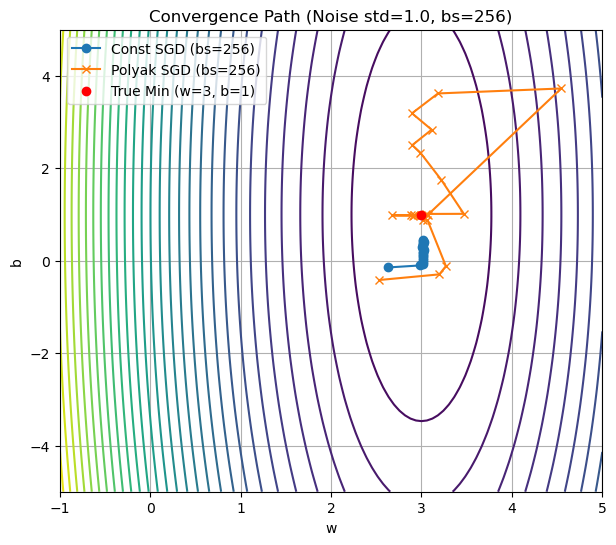

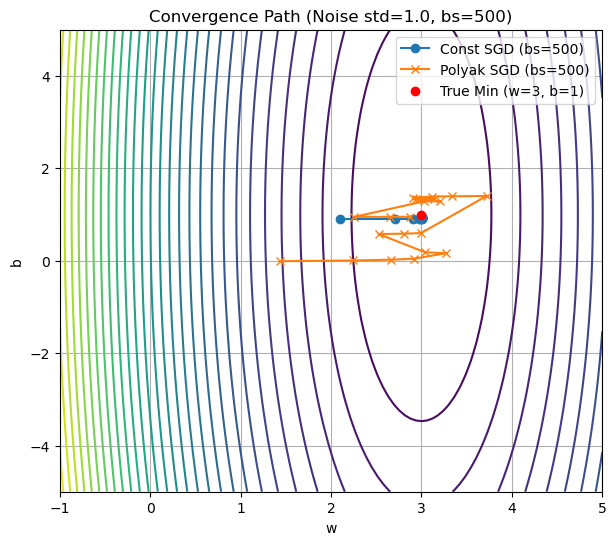

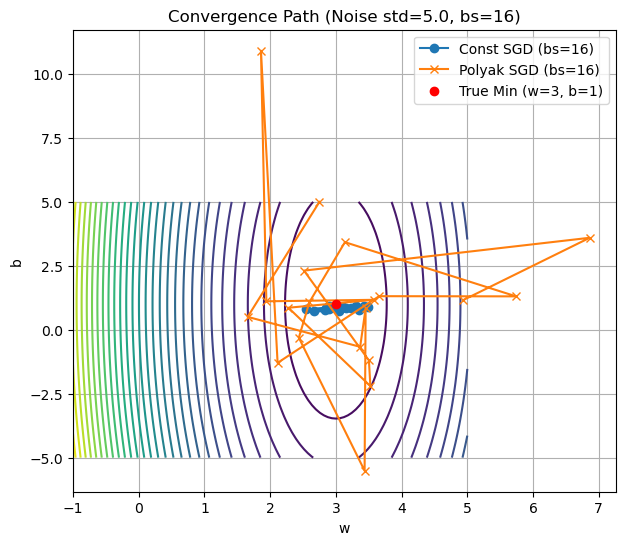

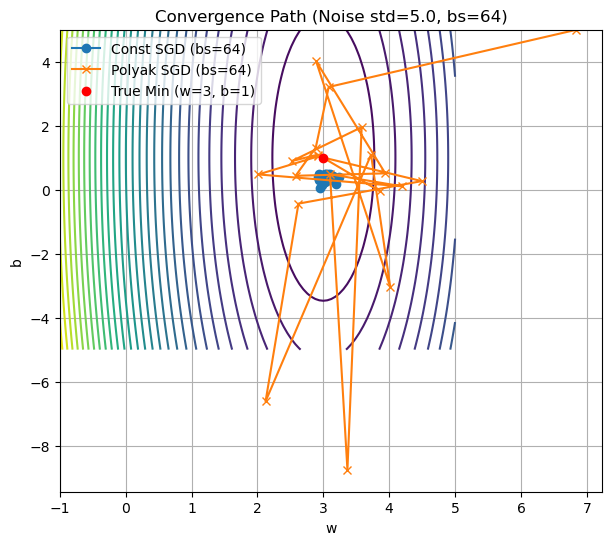

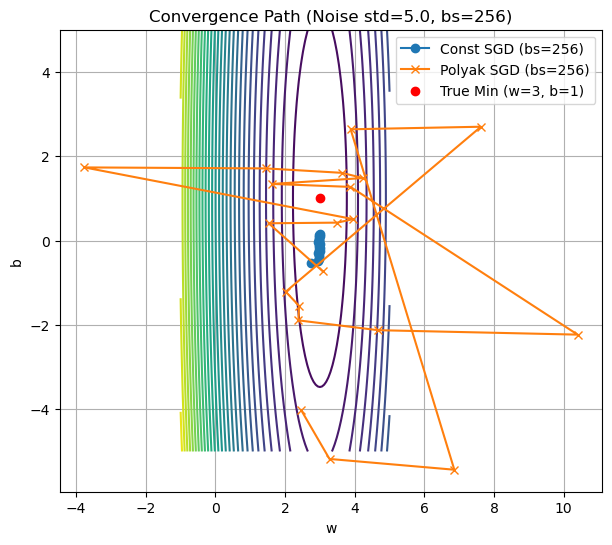

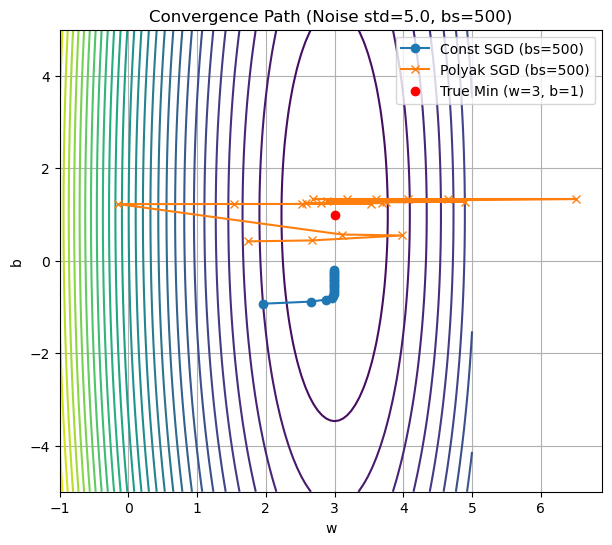

In [266]:
for noise in unique_noises:
    for key in results:
        key_noise = key.split(',')[0].split('=')[1]
        key_bs = key.split(',')[1].split('=')[1].strip()
        if key_noise == noise:
            val = results[key]
            const_path = np.array(val['const_traj'])
            poly_path = np.array(val['poly_traj'])

            # Create a contour grid
            w_vals = np.linspace(-1, 5, 100)
            b_vals = np.linspace(-5, 5, 100)
            W, B = np.meshgrid(w_vals, b_vals)
            Z = np.zeros_like(W)

            X_np = np.linspace(-10, 10, 1000).reshape(-1, 1)
            y_np = 3 * X_np + 1  # no noise for loss surface

            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    preds = W[i, j] * X_np + B[i, j]
                    Z[i, j] = np.mean((preds - y_np)**2)

            # Plot
            plt.figure(figsize=(7, 6))
            cs = plt.contour(W, B, Z, levels=30, cmap='viridis')
            # plt.clabel(cs, inline=True, fontsize=8)
            plt.plot(const_path[:, 0], const_path[:, 1], label=f'Const SGD (bs={key_bs})', marker='o')
            plt.plot(poly_path[:, 0], poly_path[:, 1], label=f'Polyak SGD (bs={key_bs})', marker='x')
            plt.scatter([3], [1], color='red', label='True Min (w=3, b=1)', zorder=5)
            plt.xlabel("w")
            plt.ylabel("b")
            plt.title(f"Convergence Path (Noise std={noise}, bs={key_bs})")
            plt.legend()
            plt.grid(True)
            plt.show()


Q1c

In [282]:

def generate_trainingdata(m=25):
    return np.array([0,0]) + 0.25 * np.random.randn(m, 2)

def f(x, minibatch):
    y = 0
    for w in minibatch:
        z = x - w - 1
        y += min(45 * (z[0]**2 + z[1]**2), (z[0]+5)**2 + (z[1]+10)**2)
    return y / len(minibatch)

T = generate_trainingdata()


In [283]:
def df_finitediff(x, minibatch, h=1e-6):
    # Calculate gradient using finite differences
    grad = np.zeros(2)
    for i in range(2):
        x_plus = x.copy()
        x_plus[i] += h
        grad[i] = (f(x_plus, minibatch) - f(x, minibatch)) / (h)
    return grad


def constant_sgd(x0, data, lr=0.1, batch_size=5, epochs=100):
    x = x0.copy()
    path = [x.copy()]
    losses = []

    for epoch in range(epochs):
        indices = np.random.permutation(len(data))  # shuffle once per epoch
        for i in range(0, len(data), batch_size):
            minibatch = data[indices[i:i + batch_size]]
            grad = np.zeros_like(x)
            for w in minibatch:
                grad += df_finitediff(x, [w])
            grad /= len(minibatch)
            x -= lr * grad

        losses.append(f(x, data))
        path.append(x.copy())

    return np.array(losses), np.array(path)

def polyak_sgd(x0, data, f_star=0.0, batch_size=5, epochs=100, epsilon=1e-8):
    x = x0.copy()
    path = [x.copy()]
    losses = []
    stepsizes = []

    for epoch in range(epochs):
        indices = np.random.permutation(len(data))  # shuffle once per epoch
        for i in range(0, len(data), batch_size):
            minibatch = data[indices[i:i + batch_size]]
            fx = f(x, minibatch)

            grad = np.zeros_like(x)
            for w in minibatch:
                grad += df_finitediff(x, [w])
            grad /= len(minibatch)

            step_size = (fx - f_star) / (np.dot(grad, grad) + epsilon)
            step_size = max(0.0, step_size)

            x -= step_size * grad

        losses.append(f(x, data))
        stepsizes.append(step_size)
        path.append(x.copy())

    return np.array(losses), np.array(stepsizes), np.array(path)








In [284]:
x0 = np.array([2.6,2.6])
epochs = 50
batch_sizes = [2, 5, 10, 25]

results = {}
T = generate_trainingdata()  # Fixed training data

for bs in batch_sizes:
    const_loss, const_path = constant_sgd(x0, T, lr=0.025, batch_size=bs, epochs=epochs)
    poly_loss, poly_steps, poly_path = polyak_sgd(x0, T, f_star=0.0, batch_size=bs, epochs=epochs)

    results[f"bs={bs}"] = {
        "const_loss": const_loss,
        "poly_loss": poly_loss,
        "poly_steps": poly_steps,
        "const_path": const_path,
        "poly_path": poly_path,
    }



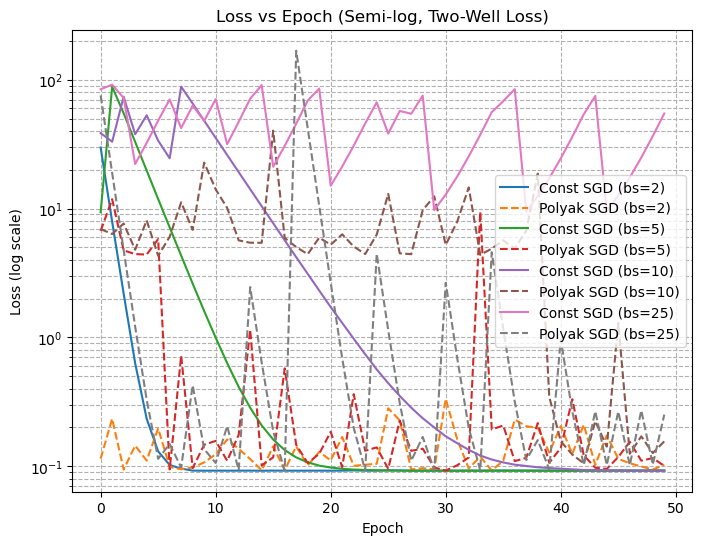

In [285]:
plt.figure(figsize=(8, 6))
for key, val in results.items():
    bs = key.split('=')[1]
    plt.semilogy(val['const_loss'], label=f"Const SGD (bs={bs})", linestyle='-')
    plt.semilogy(val['poly_loss'], label=f"Polyak SGD (bs={bs})", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs Epoch (Semi-log, Two-Well Loss)")
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()


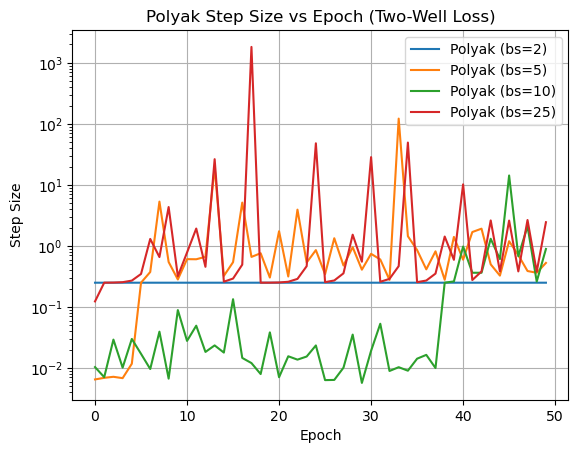

In [286]:
plt.figure()
for key, val in results.items():
    bs = key.split('=')[1]
    plt.semilogy(val['poly_steps'], label=f"Polyak (bs={bs})")
plt.xlabel("Epoch")
plt.ylabel("Step Size")
plt.title("Polyak Step Size vs Epoch (Two-Well Loss)")
plt.legend()
plt.grid(True)
plt.show()


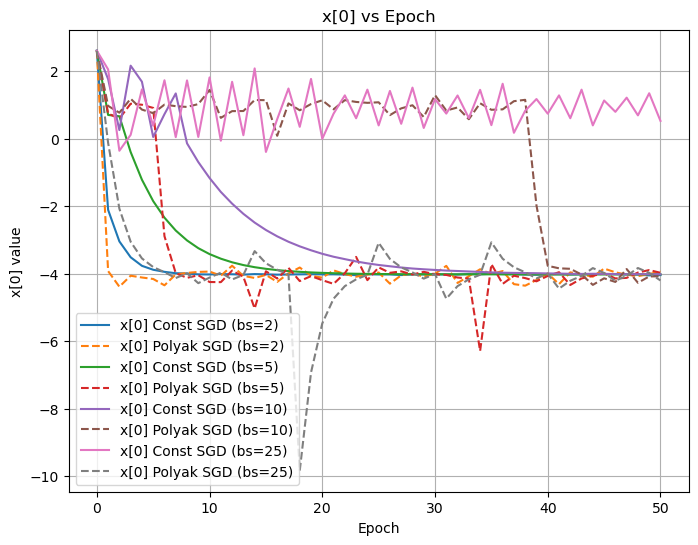

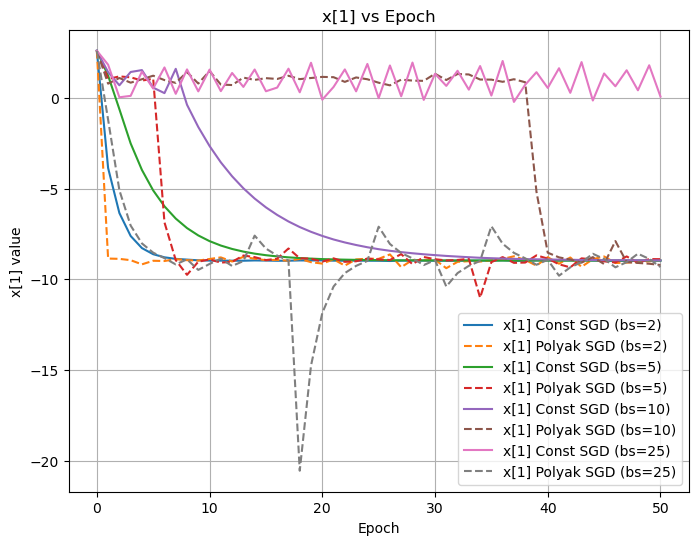

In [287]:
epochs = len(next(iter(results.values()))['const_path'])

# Plot x[0] vs Epoch
plt.figure(figsize=(8, 6))
for key, val in results.items():
    bs = key.split('=')[1]
    x0_const = val['const_path'][:, 0]
    x0_poly  = val['poly_path'][:, 0]
    plt.plot(x0_const, label=f'x[0] Const SGD (bs={bs})', linestyle='-')
    plt.plot(x0_poly, label=f'x[0] Polyak SGD (bs={bs})', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("x[0] value")
plt.title("x[0] vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Plot x[1] vs Epoch
plt.figure(figsize=(8, 6))
for key, val in results.items():
    bs = key.split('=')[1]
    x1_const = val['const_path'][:, 1]
    x1_poly  = val['poly_path'][:, 1]
    plt.plot(x1_const, label=f'x[1] Const SGD (bs={bs})', linestyle='-')
    plt.plot(x1_poly, label=f'x[1] Polyak SGD (bs={bs})', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("x[1] value")
plt.title("x[1] vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


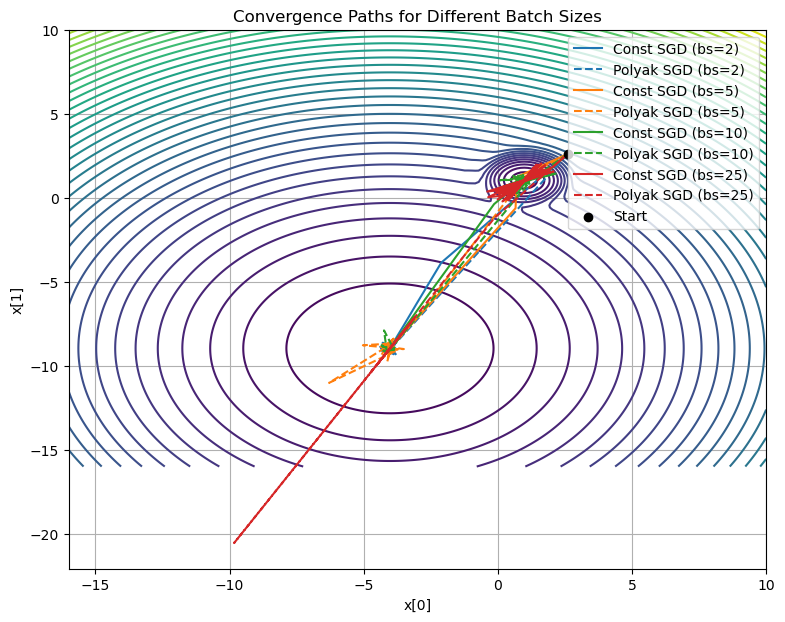

In [288]:
# Generate loss surface (shared)
x_vals = np.linspace(-16, 10, 200)
y_vals = np.linspace(-16, 10, 200)
Xg, Yg = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(Xg)
for i in range(Xg.shape[0]):
    for j in range(Xg.shape[1]):
        Z[i, j] = f(np.array([Xg[i, j], Yg[i, j]]), T)

# Define batch size colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
batch_sizes = list(results.keys())

# Plot all in one figure
plt.figure(figsize=(9, 7))
cs = plt.contour(Xg, Yg, Z, levels=50, cmap='viridis')
# plt.clabel(cs, inline=True, fontsize=8)

for idx, key in enumerate(batch_sizes):
    bs = key.split('=')[1]
    val = results[key]
    const_path = val['const_path']
    poly_path = val['poly_path']

    plt.plot(const_path[:, 0], const_path[:, 1], linestyle='-', color=colors[idx], label=f'Const SGD (bs={bs})')
    plt.plot(poly_path[:, 0], poly_path[:, 1], linestyle='--', color=colors[idx], label=f'Polyak SGD (bs={bs})')

plt.scatter([x0[0]], [x0[1]], color='black', label='Start', zorder=5)
plt.xlabel("x[0]")
plt.ylabel("x[1]")
plt.title("Convergence Paths for Different Batch Sizes")
plt.legend()
plt.grid(True)
plt.show()


Q1e

Running experiments...
Analyzing results...


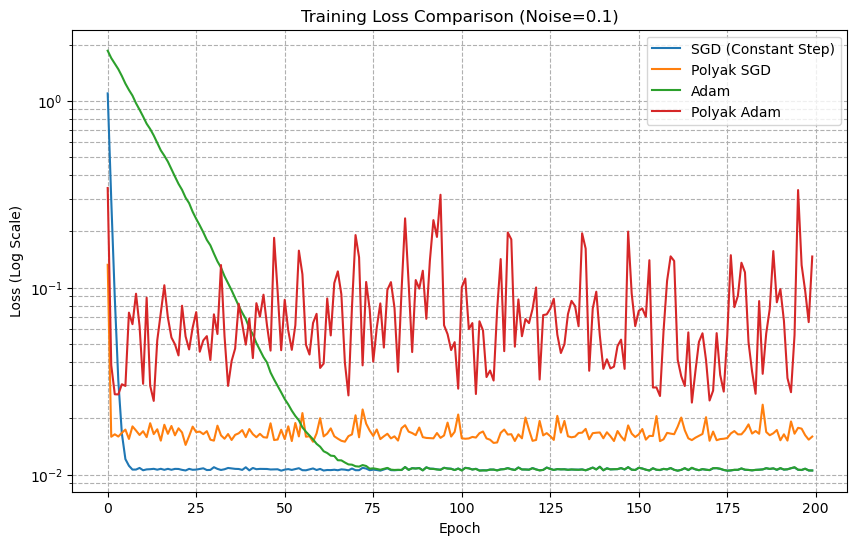

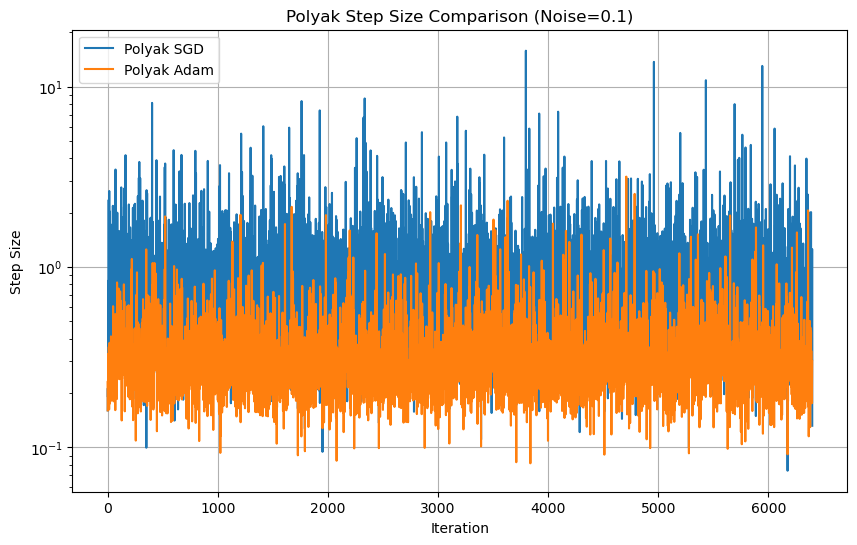

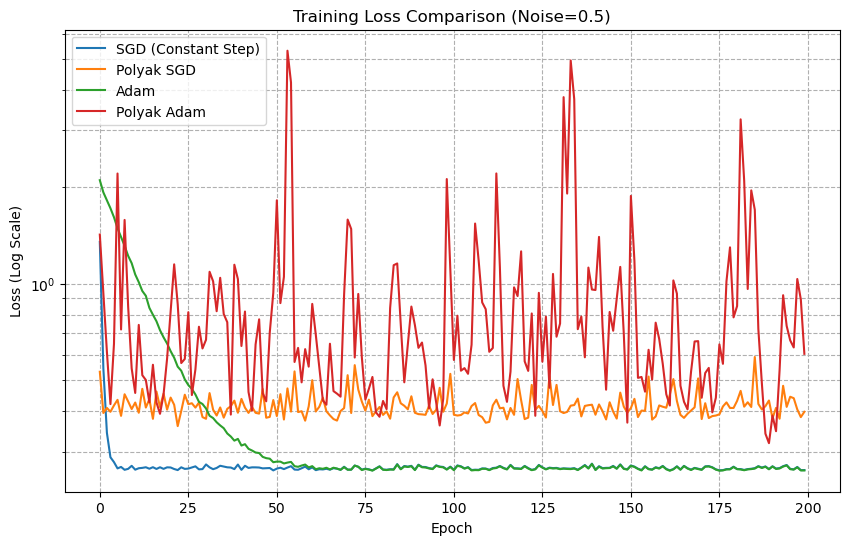

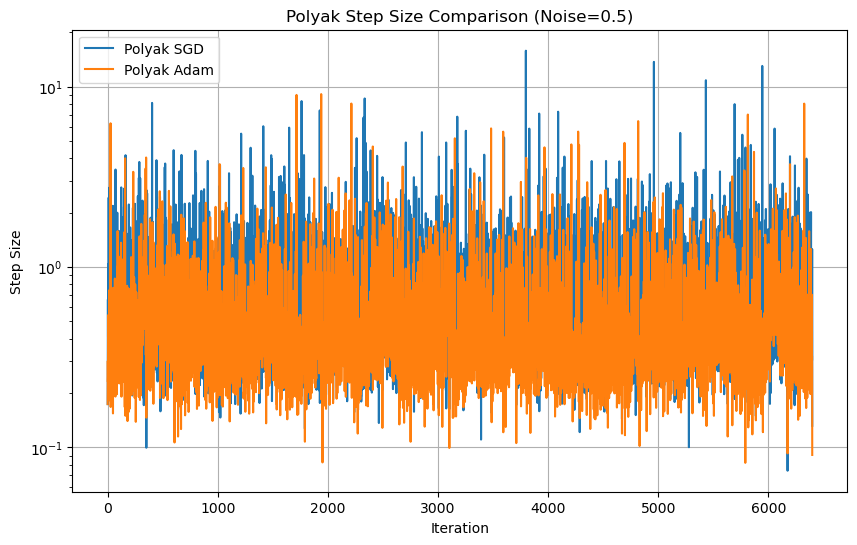

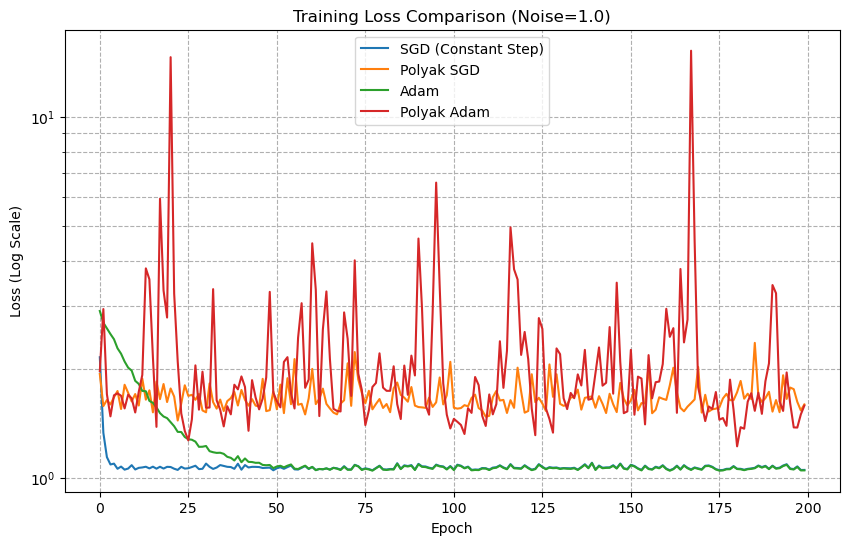

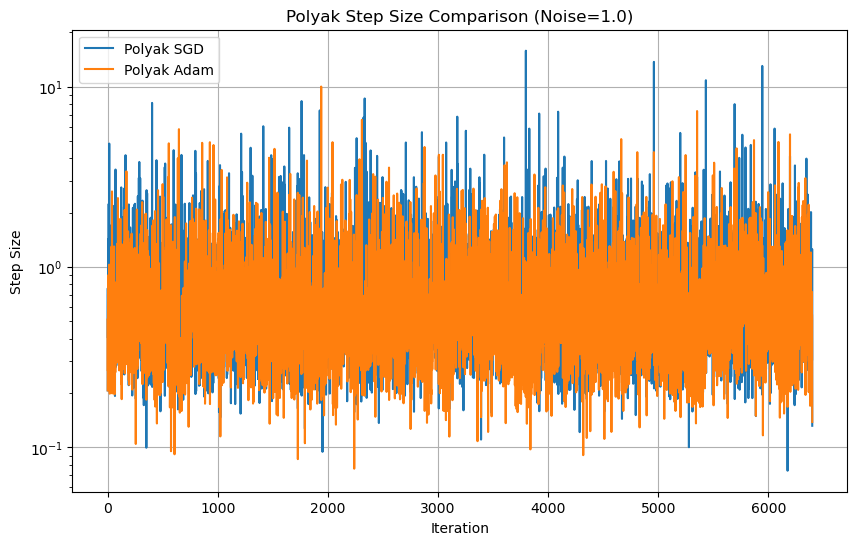

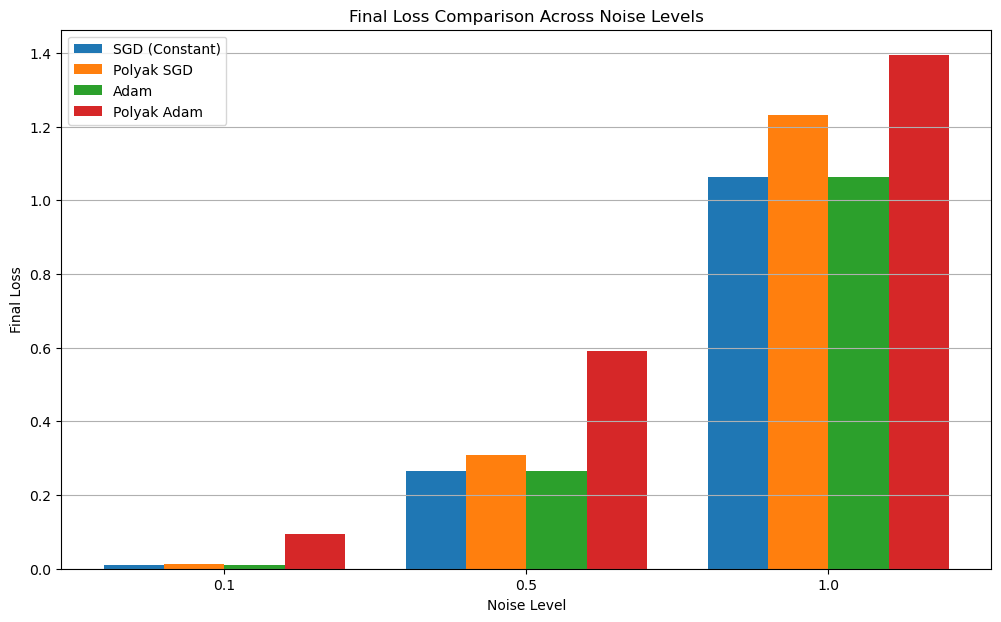

In [ ]:

class PolyakAdam(torch.optim.Optimizer):

    
    def __init__(self, params, betas=(0.9, 0.999), eps=1e-8, f_star=0.0, weight_decay=0):
        defaults = dict(betas=betas, eps=eps, f_star=f_star, weight_decay=weight_decay)
        super(PolyakAdam, self).__init__(params, defaults)
        self.step_sizes = []  # Store step sizes for analysis
        
    def step(self, closure=None):
   
        if closure is None:
            raise ValueError("PolyakAdam requires closure to compute the current loss value")
            
        # Get current loss value
        loss = closure()
        
        # Calculate squared norm of the gradient (for Polyak step size)
        grad_squared_norm = 0.0
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                grad_squared_norm += torch.sum(grad * grad).item()
        
        # Calculate Polyak step size
        f_star = self.param_groups[0]['f_star']  # Assuming same f_star for all groups
        eps = self.param_groups[0]['eps']  # Using eps from Adam for numerical stability
        
        polyak_step_size = (loss.item() - f_star) / (grad_squared_norm + eps)
        polyak_step_size = max(polyak_step_size, 0.0)  # Ensure non-negative
        
        # Store step size for analysis
        self.step_sizes.append(polyak_step_size)
        
        # Standard Adam update logic with Polyak step size
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                grad = p.grad.data
                
                # Apply weight decay if specified
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)
                
                # State initialization
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                
                state['step'] += 1
                
                # Update biased first moment estimate (momentum)
                state['exp_avg'].mul_(beta1).add_(grad, alpha=1 - beta1)
                # Update biased second raw moment estimate
                state['exp_avg_sq'].mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                
                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                # Original Adam would use a specified learning rate here
                # Instead, we use the Polyak step size
                
                # Compute Adam update direction (without step size)
                denom = (torch.sqrt(state['exp_avg_sq']) / np.sqrt(bias_correction2)).add_(eps)
                update = state['exp_avg'] / bias_correction1 / denom
                
                # Apply update using Polyak step size
                p.data.add_(update, alpha=-polyak_step_size)
        
        return loss


def generate_linear_data(n_samples, n_features, noise_level, seed=42):
 
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Generate true parameters
    w_true = torch.randn(n_features)
    b_true = torch.randn(1).item()
        
    # Generate features
    X = torch.randn(n_samples, n_features)
    
    # Generate noisy targets
    y = X @ w_true + b_true + noise_level * torch.randn(n_samples)
    
    return X, y, (w_true, b_true)


def compare_optimizers(noise_levels=[0.1, 0.5, 1.0], n_samples=1000, n_features=5, batch_size=32, n_epochs=200):

    results = {}
    
    # Define optimizer settings
    sgd_lr = 0.01
    adam_lr = 0.001
    
    for noise in noise_levels:
        # Generate data with this noise level
        X, y, true_params = generate_linear_data(n_samples, n_features, noise)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize models - one for each optimizer
        model_sgd = torch.nn.Linear(n_features, 1)
        model_polyak_sgd = copy.deepcopy(model_sgd)
        model_adam = copy.deepcopy(model_sgd)
        model_polyak_adam = copy.deepcopy(model_sgd)
        
        # Initialize optimizers
        opt_sgd = torch.optim.SGD(model_sgd.parameters(), lr=sgd_lr)
        
        opt_polyak_sgd = PolyakSGD(model_polyak_sgd.parameters())
        
        opt_adam = torch.optim.Adam(model_adam.parameters(), lr=adam_lr)
        
        opt_polyak_adam = PolyakAdam(model_polyak_adam.parameters())
        
        # Loss function
        criterion = torch.nn.MSELoss()
        
        # Training history
        sgd_losses = []
        polyak_sgd_losses = []
        adam_losses = []
        polyak_adam_losses = []
        
        polyak_sgd_steps = []
        polyak_adam_steps = []
        
        # Train for n_epochs
        for epoch in range(n_epochs):
            # Track epoch losses
            sgd_epoch_loss = 0
            polyak_sgd_epoch_loss = 0
            adam_epoch_loss = 0
            polyak_adam_epoch_loss = 0
            
            for X_batch, y_batch in dataloader:
                y_batch = y_batch.view(-1, 1)
                
                # Train with SGD (constant step size)
                opt_sgd.zero_grad()
                pred_sgd = model_sgd(X_batch)
                loss_sgd = criterion(pred_sgd, y_batch)
                loss_sgd.backward()
                opt_sgd.step()
                sgd_epoch_loss += loss_sgd.item()
                
                # Train with Polyak SGD
                def closure_polyak_sgd():
                    opt_polyak_sgd.zero_grad()
                    pred = model_polyak_sgd(X_batch)
                    loss = criterion(pred, y_batch)
                    loss.backward()
                    return loss
                
                loss_polyak_sgd = opt_polyak_sgd.step(closure_polyak_sgd)
                polyak_sgd_epoch_loss += loss_polyak_sgd.item()
                
                # Train with standard Adam
                opt_adam.zero_grad()
                pred_adam = model_adam(X_batch)
                loss_adam = criterion(pred_adam, y_batch)
                loss_adam.backward()
                opt_adam.step()
                adam_epoch_loss += loss_adam.item()
                
                # Train with Polyak Adam
                def closure_polyak_adam():
                    opt_polyak_adam.zero_grad()
                    pred = model_polyak_adam(X_batch)
                    loss = criterion(pred, y_batch)
                    loss.backward()
                    return loss
                
                loss_polyak_adam = opt_polyak_adam.step(closure_polyak_adam)
                polyak_adam_epoch_loss += loss_polyak_adam.item()
            
            # Record average loss for the epoch
            sgd_losses.append(sgd_epoch_loss / len(dataloader))
            polyak_sgd_losses.append(polyak_sgd_epoch_loss / len(dataloader))
            adam_losses.append(adam_epoch_loss / len(dataloader))
            polyak_adam_losses.append(polyak_adam_epoch_loss / len(dataloader))
        
        # Store step sizes for analysis
        polyak_sgd_steps = opt_polyak_sgd.step_sizes
        polyak_adam_steps = opt_polyak_adam.step_sizes
        
        # Evaluate final models on the full dataset
        with torch.no_grad():
            pred_sgd = model_sgd(X)
            final_loss_sgd = criterion(pred_sgd, y.view(-1, 1)).item()
            
            pred_polyak_sgd = model_polyak_sgd(X)
            final_loss_polyak_sgd = criterion(pred_polyak_sgd, y.view(-1, 1)).item()
            
            pred_adam = model_adam(X)
            final_loss_adam = criterion(pred_adam, y.view(-1, 1)).item()
            
            pred_polyak_adam = model_polyak_adam(X)
            final_loss_polyak_adam = criterion(pred_polyak_adam, y.view(-1, 1)).item()
        
        # Store results
        results[noise] = {
            'sgd_losses': sgd_losses,
            'polyak_sgd_losses': polyak_sgd_losses,
            'adam_losses': adam_losses,
            'polyak_adam_losses': polyak_adam_losses,
            'polyak_sgd_steps': polyak_sgd_steps,
            'polyak_adam_steps': polyak_adam_steps,
            'final_loss_sgd': final_loss_sgd,
            'final_loss_polyak_sgd': final_loss_polyak_sgd,
            'final_loss_adam': final_loss_adam,
            'final_loss_polyak_adam': final_loss_polyak_adam
        }
    
    return results


def analyze_results(results, noise_levels):
    """
    Analyze and plot results from the optimizer comparison experiment
    """
    # Create plots for each noise level
    for noise in noise_levels:
        res = results[noise]
        
        # 1. Plot training losses for all optimizers
        plt.figure(figsize=(10, 6))
        plt.semilogy(res['sgd_losses'], label='SGD (Constant Step)')
        plt.semilogy(res['polyak_sgd_losses'], label='Polyak SGD')
        plt.semilogy(res['adam_losses'], label='Adam')
        plt.semilogy(res['polyak_adam_losses'], label='Polyak Adam')

        plt.title(f'Training Loss Comparison (Noise={noise})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Log Scale)')
        plt.legend()
        plt.grid(True, which="both", linestyle='--')
        plt.show()

        
        # 2. Plot step sizes for Polyak methods
        plt.figure(figsize=(10, 6))
        plt.semilogy(res['polyak_sgd_steps'], label='Polyak SGD')
        plt.semilogy(res['polyak_adam_steps'], label='Polyak Adam')
        
        plt.title(f'Polyak Step Size Comparison (Noise={noise})')
        plt.xlabel('Iteration')
        plt.ylabel('Step Size')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # 3. Compare final losses across noise levels
    plt.figure(figsize=(12, 7))
    
    x = np.arange(len(noise_levels))
    width = 0.2
    
    sgd_losses = [results[noise]['final_loss_sgd'] for noise in noise_levels]
    polyak_sgd_losses = [results[noise]['final_loss_polyak_sgd'] for noise in noise_levels]
    adam_losses = [results[noise]['final_loss_adam'] for noise in noise_levels]
    polyak_adam_losses = [results[noise]['final_loss_polyak_adam'] for noise in noise_levels]
    
    plt.bar(x - 1.5*width, sgd_losses, width, label='SGD (Constant)')
    plt.bar(x - 0.5*width, polyak_sgd_losses, width, label='Polyak SGD')
    plt.bar(x + 0.5*width, adam_losses, width, label='Adam')
    plt.bar(x + 1.5*width, polyak_adam_losses, width, label='Polyak Adam')
    
    plt.xlabel('Noise Level')
    plt.ylabel('Final Loss')
    plt.title('Final Loss Comparison Across Noise Levels')
    plt.xticks(x, [str(n) for n in noise_levels])
    plt.legend()
    plt.grid(True, axis='y')
    plt.show()
    
    return {
        'noise_levels': noise_levels,
        'sgd_losses': sgd_losses,
        'polyak_sgd_losses': polyak_sgd_losses,
        'adam_losses': adam_losses,
        'polyak_adam_losses': polyak_adam_losses
    }


# Set experiment parameters
noise_levels = [0.1, 0.5, 1.0]

# Run experiments
print("Running experiments...")
results = compare_optimizers(noise_levels)

# Analyze results
print("Analyzing results...")
summary = analyze_results(results, noise_levels)
    
